Processing C:/Users/USER/Desktop/20240628/data/donut_subimages_CY\subimage_1.png
Outer Circle: Center = (27, 28), Radius = 18
Inner Circle: Center = (27, 28), Radius = 9.0
Outer Diameter: 36 pixels
Inner Diameter: 18 pixels
Processing C:/Users/USER/Desktop/20240628/data/donut_subimages_CY\subimage_10.png
Outer Circle: Center = (49, 48), Radius = 39
Inner Circle: Center = (49, 48), Radius = 30.0
Outer Diameter: 78 pixels
Inner Diameter: 60 pixels
Processing C:/Users/USER/Desktop/20240628/data/donut_subimages_CY\subimage_11.png
Outer Circle: Center = (48, 48), Radius = 39
Inner Circle: Center = (48, 48), Radius = 29.5
Outer Diameter: 78 pixels
Inner Diameter: 59 pixels
Processing C:/Users/USER/Desktop/20240628/data/donut_subimages_CY\subimage_12.png
Outer Circle: Center = (28, 27), Radius = 18
Inner Circle: Center = (28, 27), Radius = 9.0
Outer Diameter: 36 pixels
Inner Diameter: 18 pixels
Processing C:/Users/USER/Desktop/20240628/data/donut_subimages_CY\subimage_13.png
Outer Circle: Cen

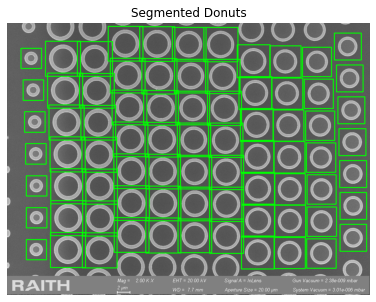

Saved 77 valid subimages to C:/Users/USER/Desktop/20240628/data/donut_subimages_CY


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ref_points = []
selecting = True

def select_points(event, x, y, flags, param):
    global ref_points, selecting
    
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_points.append((x, y))
        
        if len(ref_points) == 2:
            selecting = False

def is_donut(contour):
    # 檢查是否為完整的甜甜圈
    
    # 計算輪廓的面積
    area = cv2.contourArea(contour)
    
    # 計算輪廓的外接圓半徑
    (x, y), radius = cv2.minEnclosingCircle(contour)
    circle_area = np.pi * radius * radius
    
    # 計算圓度（circularity）
    circularity = area / circle_area
    
    # 判斷是否為完整的甜甜圈
    if circularity > 0.6:  # 調整圓度閾值來確保只有完整的甜甜圈被分割出來
        return True
    else:
        return False

def segment_and_display_donuts(image_path, save_path, lower=127, upper=255, dummy_px = 10):
    global ref_points, selecting
    
    # 讀取圖像
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return
    
    # 顯示圖像並選擇參考點
    clone = image.copy()
    cv2.namedWindow("Select Reference Points")
    cv2.setMouseCallback("Select Reference Points", select_points, clone)
    
    while selecting:
        cv2.imshow("Select Reference Points", clone)
        cv2.waitKey(1)
    
    cv2.destroyAllWindows()
    
    # 計算像素距離
    if len(ref_points) == 2:
        pixel_distance = np.sqrt((ref_points[0][0] - ref_points[1][0]) ** 2 + (ref_points[0][1] - ref_points[1][1]) ** 2)
        print(f"Pixel distance: {pixel_distance:.2f} pixels")
        
        # 輸入參考長度，確保輸入為有效數字
        while True:
            try:
                reference_length = float(input("Enter the actual reference length in units: "))
                break
            except ValueError:
                print("Invalid input. Please enter a valid number.")
    
    # 二值化圖像
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, lower, upper, cv2.THRESH_BINARY)
    
    # 找到輪廓
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 確保保存路徑存在
    os.makedirs(save_path, exist_ok=True)
    
    # 提取每個甜甜圈的子圖像並保存
    valid_donuts_count = 0
    for i, contour in enumerate(contours):
        # 檢查是否為完整的甜甜圈
        if is_donut(contour):
            valid_donuts_count += 1
            
            # 獲取外接矩形範圍
            x, y, w, h = cv2.boundingRect(contour)
            
            # 計算甜甜圈直徑（以像素為單位）
            donut_diameter_pixels = max(w, h)
            
            # 轉換成實際單位（如厘米）
            if pixel_distance > 0 and reference_length > 0:
                pixel_per_unit = pixel_distance / reference_length
                donut_diameter_units = donut_diameter_pixels / pixel_per_unit
                print(f"Donut {valid_donuts_count}: Diameter = {donut_diameter_units:.2f} units")
            
            # 提取子圖像
            ymin = y - dummy_px
            xmin = x - dummy_px
            new_h = h + 2*dummy_px
            new_w = w + 2*dummy_px
            ymax = ymin + new_h
            xmax = xmin + new_w
            subimage = clone[ymin:ymax, xmin:xmax]
            
            # 生成保存路徑和文件名
            save_file = os.path.join(save_path, f"subimage_{valid_donuts_count}.png")
            
            # 保存子圖像
            cv2.imwrite(save_file, subimage)
            
            # 在原始圖像上標記分割的甜甜圈
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            # image draw a rectangle
            
    # 顯示原始圖像
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Donuts")
    plt.axis('off')
    plt.show()
    
    print(f"Saved {valid_donuts_count} valid subimages to {save_path}")

##判斷子圓圈的內外圈

def get_donut_radius(image_path, lower=140, upper=255):
    # 讀取圖像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 二值化圖像
    _, binary_image = cv2.threshold(image, lower, upper, cv2.THRESH_BINARY)
    
    # 找到輪廓
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 使用subplot顯示圖像
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary Image")
    """
# 找到最大的輪廓，即甜甜圈的外輪廓
    largest_contour = max(contours, key=cv2.contourArea)

    # 獲取外接圓
    (x_outer, y_outer), radius_outer = cv2.minEnclosingCircle(largest_contour)

    # 圓心取整
    center_outer = (int(x_outer), int(y_outer))
    radius_outer = int(radius_outer)

    # 通過圓心的水平線上的灰階值變化
    row_values = binary_image[center_outer[1], :].astype(float)
    changes = np.diff(row_values)
    nonzero_indices = np.nonzero(changes)
    # 假設內圓的灰階值變化最明顯，因此內圓的邊界應該是變化最大的位置
    radius_inner = (nonzero_indices[0][2] - nonzero_indices[0][1])/2
    # 顯示結果
    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    """
    cv2.circle(result_image, center_outer, radius_outer, (0, 255, 0), 2)
    cv2.circle(result_image, center_outer, 2, (255, 0, 0), 3) # 圓心

    # 畫出內圓
    if radius_inner > 0:
        cv2.circle(result_image, center_outer, int(radius_inner), (0, 0, 255), 2)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Donut")
    plt.show()
    """
 # 輸出結果
    outer_diameter = int(2 * radius_outer)
    inner_diameter = int(2 * radius_inner)
    print(f"Outer Circle: Center = {center_outer}, Radius = {radius_outer}")
    print(f"Inner Circle: Center = {center_outer}, Radius = {radius_inner}")
    print(f"Outer Diameter: {outer_diameter} pixels")
    print(f"Inner Diameter: {inner_diameter} pixels")
    return center_outer, outer_diameter, inner_diameter

# 設定影像資料夾路徑
image_folder = 'C:/Users/USER/Desktop/20240628/data/donut_subimages_CY'

# 準備資料框架來儲存結果
results = []

# 迭代資料夾中的每一張影像
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        image_path = os.path.join(image_folder, filename)
        print(f"Processing {image_path}")
        center_outer, outer_diameter, inner_diameter = get_donut_radius(image_path, lower=140, upper = 255)
        results.append([filename, center_outer, outer_diameter, inner_diameter])

# 將結果寫入 Excel
df = pd.DataFrame(results, columns=['Filename', 'Center', 'Outer Diameter (pixels)', 'Inner Diameter (pixels)'])
output_excel = 'C:/Users/USER/Desktop/20240628/data/donut_diameters.xlsx'
df.to_excel(output_excel, index=False)

print(f"Results have been written to {output_excel}")

# 測試函數
# test_image_path是輸入影像，可以丟任何跟圓形相關需要計算直徑
# save_folder_path是影像分割後儲存的地方
test_image_path = 'C:/Users/USER/Desktop/20240628/data/M1M4_Newfixed_oxide_8_89.png'
save_folder_path = 'C:/Users/USER/Desktop/20240628/data/donut_subimages_CY'
segment_and_display_donuts(test_image_path, save_folder_path)